In [31]:
import sys
import importlib
import os

parent_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_path not in sys.path:
    sys.path.insert(0, parent_path)
    
import utils
importlib.reload(utils)
from utils import *

import files
importlib.reload(files)
from files import *

In [32]:
for city, path in files.items():
      globals()[f"consommation_heat_{city}"] = extract_columns(files[city])

for city2, path2 in files.items():
      globals()[f"consommation_cool_{city2}"] = extract_columns(files[city2],5)  

In [7]:
"""
Décomposition du DataFrame de consommation de chauffage à Toulouse  périphérie  en  6h. 
Ajout d'une colonne binaire pour identifier les jours de consommation
Clustering appliqué sur chaque sous-partie avec la possibilité de définir le nombre de clusters pour chaque segment via la liste `n_clusters_list`.  
Les résultats de chaque sous-partie, avec leurs clusters respectifs, sont stockés dans les DataFrames `df_part*`.
"""

df_combined_tou = pd.concat([consommation_heat_agen, consommation_heat_albi,consommation_heat_auch,consommation_heat_toulouse], axis=0).reset_index(drop=True)
df_final_tou=add_binary_column(df_combined_tou, column_name="heat_on")

cols_1 = list(range(0, 6)) + [-1]
cols_2 = list(range(6, 12)) + [-1]  
cols_3 = list(range(12, 17)) + [-1] 
cols_4 = list(range(17, 24)) + [-1]
cols_list = [cols_1, cols_2, cols_3, cols_4]
n_clusters_list = [3, 4, 4, 3]

clustered_dfs = cluster_data(df_combined_tou, 'heat_on', n_clusters_list, cols_list)     
df_part1 = clustered_dfs['df_part1']
df_part2 = clustered_dfs['df_part2'] 
df_part3 = clustered_dfs['df_part3']
df_part4 = clustered_dfs['df_part4']



C:\Users\toubia\stage-rep\stage_new\final\utils.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part.loc[df_part[heat_on_column] == 1, 'clusters'] = model.labels_
C:\Users\toubia\stage-rep\stage_new\final\utils.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part.loc[df_part[heat_on_column] == 1, 'clusters'] = model.labels_
C:\Users\toubia\stage-rep\stage_new\final\utils.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

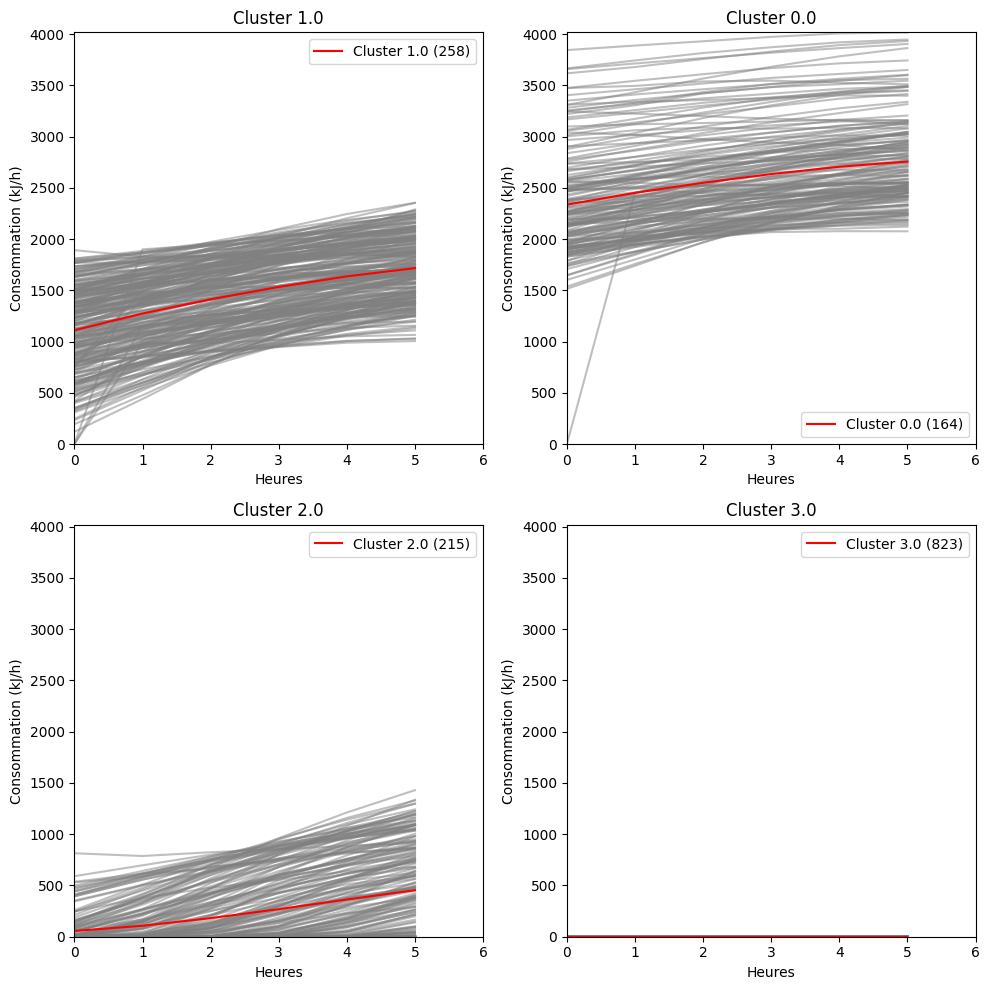

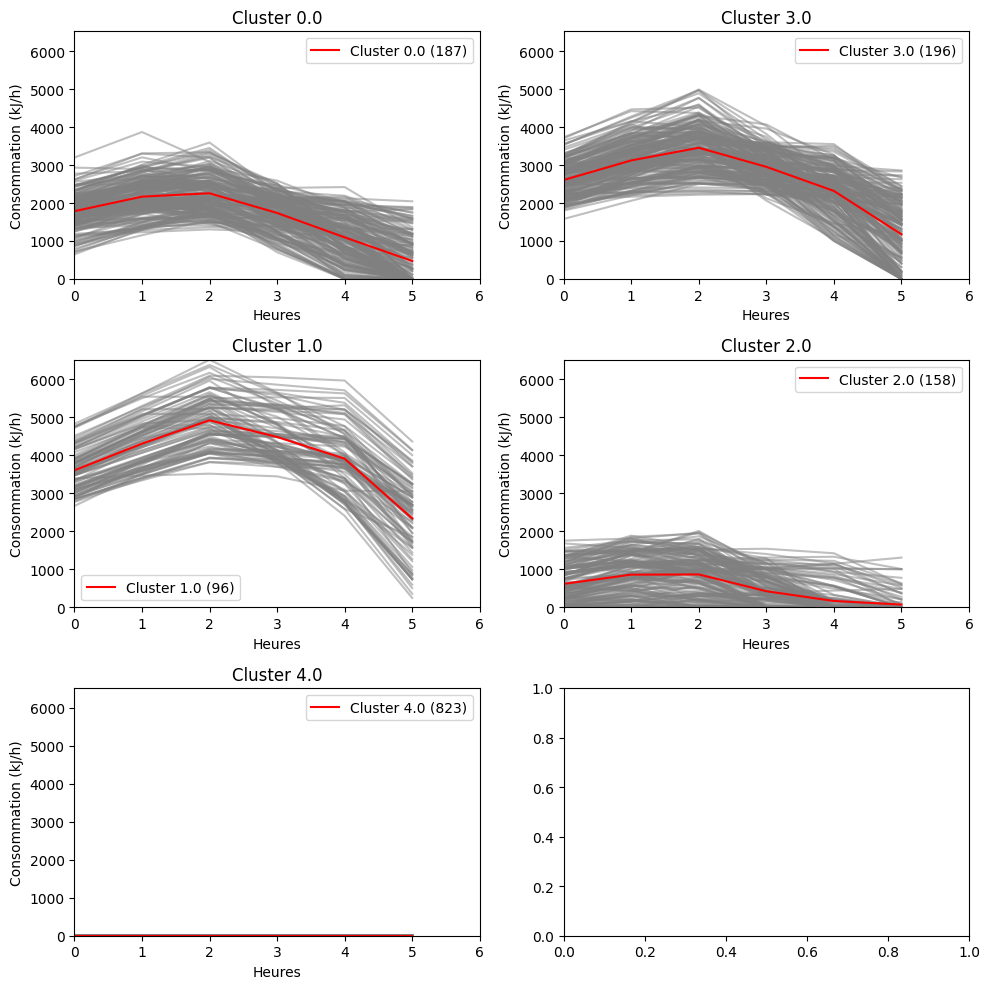

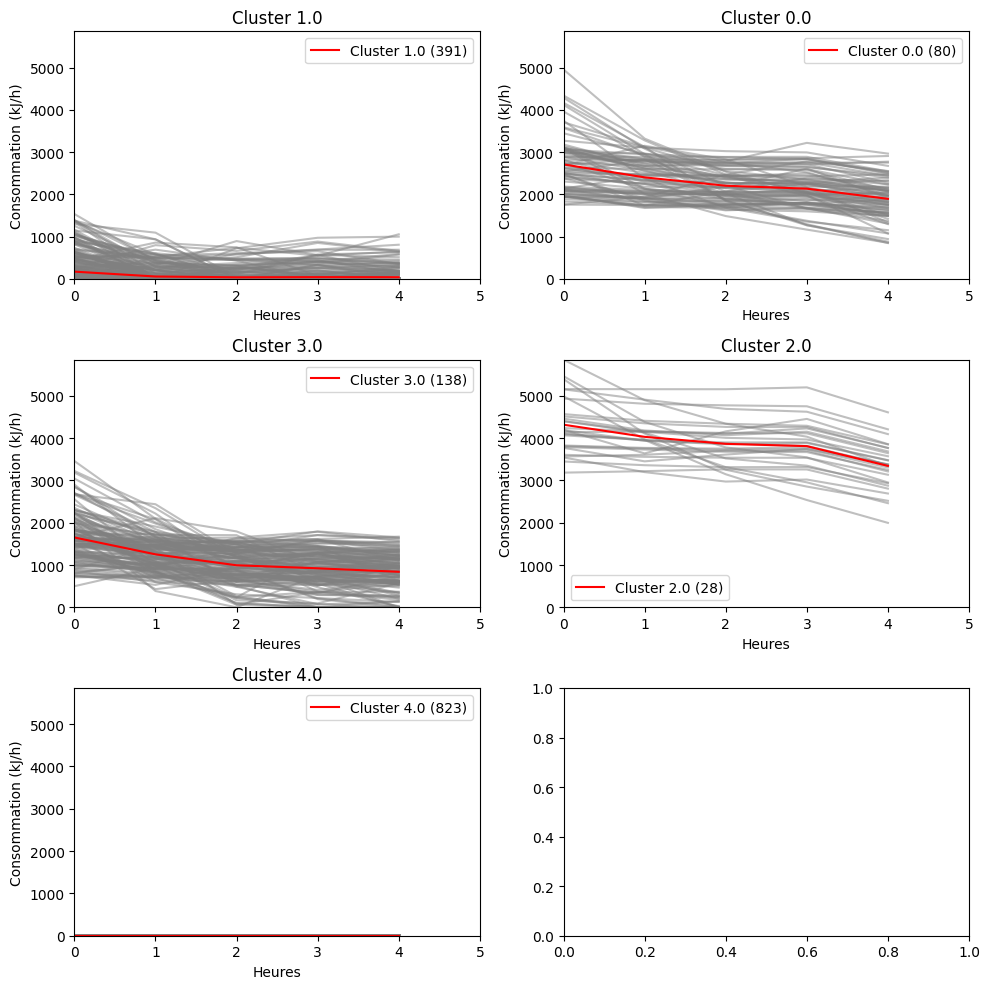

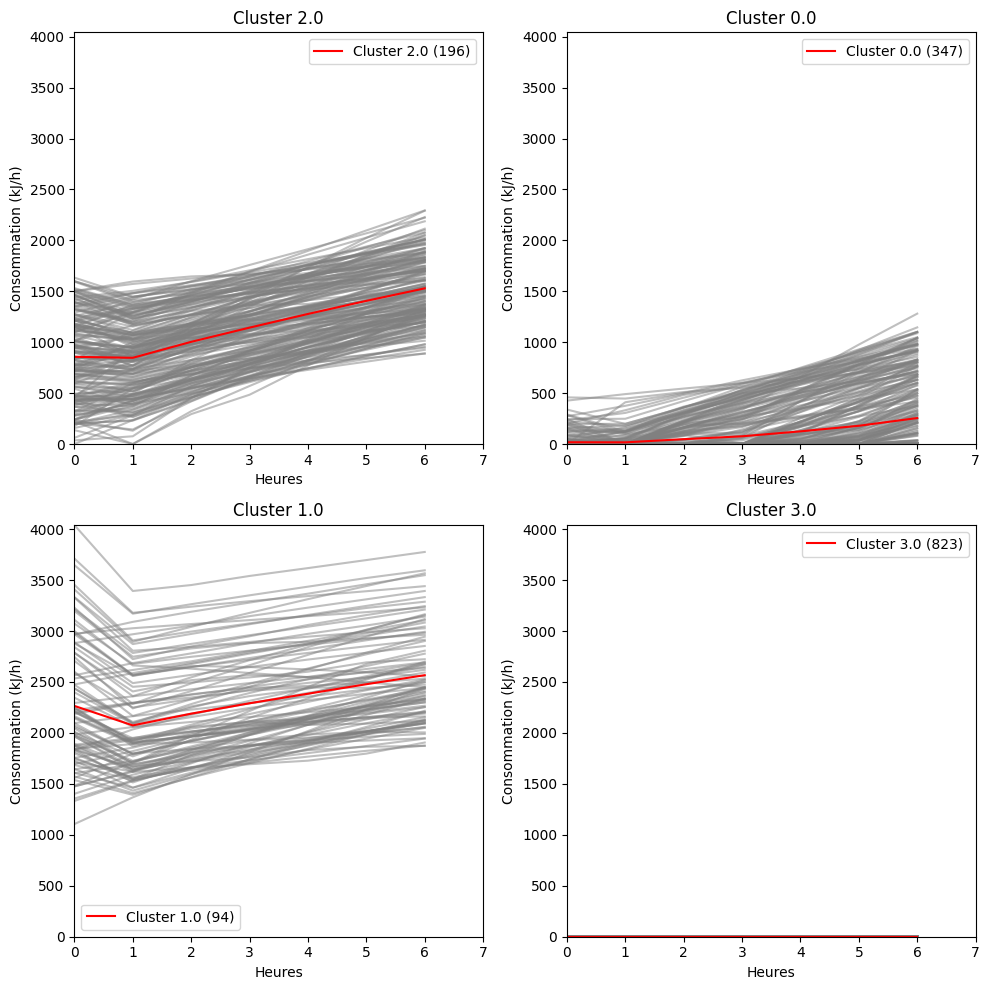

In [8]:
"""
Visualisation de la distribution des séries de consommation pour chaque sous-partie selon les clusters attribués.
"""

plot_clusters(df_part1.drop(columns=["heat_on"]))
plot_clusters(df_part2.drop(columns=["heat_on"]))
plot_clusters(df_part3.drop(columns=["heat_on"]))
plot_clusters(df_part4.drop(columns=["heat_on"]))

In [5]:
"""
Calcul des centres de clusters pour chaque sous-partie, puis évaluation de la qualité du clustering à l’aide des métriques MAE, MSE et RMSE pour chaque cluster.
Les résultats sont ensuite agrégés pour obtenir les performances globales de chaque sous-partie, puis une moyenne générale est calculée.
"""

dfs_parts = {"df_part1": df_part1, "df_part2": df_part2, "df_part3": df_part3, "df_part4": df_part4}
centers_per_part = {part: compute_cluster_centers(df) for part, df in dfs_parts.items()}

def compute_metrics_per_part(df_part):  
    centers_df = compute_cluster_centers(df_part) 
    cluster_centers = centers_df.values 
    metrics = []
    total_samples = len(df_part)

    for cluster_id in df_part["clusters"].unique():
        cluster_data = df_part[df_part["clusters"] == cluster_id].drop(columns=["heat_on", "clusters"])
        cluster_center = centers_df.loc[cluster_id].values
        mse_total, mae_total, rmse_total = 0, 0, 0

        for _, row in cluster_data.iterrows():
            mse, mae, rmse = calculate_metrics(row.values, cluster_center)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse

        num_series = len(cluster_data)

        metrics.append({
            "cluster_id": cluster_id,
            "num_series": num_series,
            "mse": mse_total / num_series,
            "mae": mae_total / num_series,
            "rmse": rmse_total / num_series
        })

    metrics_df = pd.DataFrame(metrics)

    global_metrics = {
        "mse_global": (metrics_df["mse"] * metrics_df["num_series"]).sum() / total_samples,
        "mae_global": (metrics_df["mae"] * metrics_df["num_series"]).sum() / total_samples,
        "rmse_global": (metrics_df["rmse"] * metrics_df["num_series"]).sum() / total_samples
    }

    return metrics_df, global_metrics

metrics_results = {part: compute_metrics_per_part(df) for part, df in dfs_parts.items()}

all_metrics_dfs = {part: metrics_df for part, (metrics_df, _) in metrics_results.items()}
all_global_metrics = {part: global_metrics for part, (_, global_metrics) in metrics_results.items()}

for part, metrics_df in all_metrics_dfs.items():
    print(f"\nMétriques pour chaque cluster dans la partition {part}:")
    print(metrics_df)

global_metrics_combined = pd.DataFrame(all_global_metrics).T  
avg_metrics = global_metrics_combined[['mse_global', 'mae_global', 'rmse_global']].mean()

print("\nMétriques globales par partition:")
print(global_metrics_combined)  
print("\nMoyennes des métriques globales sur toutes les partitions:")
print(avg_metrics)  




Métriques pour chaque cluster dans la partition df_part1:
   cluster_id  num_series            mse         mae        rmse
0         1.0         257  116974.996981  290.508448  305.029442
1         0.0         164  212724.069646  366.543119  378.020604
2         2.0         216   96779.626387  248.835302  280.034901
3         3.0         823       0.000000    0.000000    0.000000

Métriques pour chaque cluster dans la partition df_part2:
   cluster_id  num_series            mse         mae        rmse
0         2.0         203  280421.917367  427.267253  503.074052
1         1.0         180  361467.083323  481.289921  566.199878
2         3.0          65  411391.965281  533.246635  596.620588
3         0.0         189  245253.790027  397.493955  467.062981
4         4.0         823       0.000000    0.000000    0.000000

Métriques pour chaque cluster dans la partition df_part3:
   cluster_id  num_series            mse         mae        rmse
0         2.0         391   38763.588397  1

In [6]:
"""
Combinaison des sous-parties pour former une journée complète de 24 heures. 
Chaque sous-partie est associée à une colonne de cluster. 
Il y a ainsi 4 colonnes de clusters au total
"""

clusters = [
    df_part1.iloc[:, -1], 
    df_part2.iloc[:, -1], 
    df_part3.iloc[:, -1], 
    df_part4.iloc[:, -1]
]

combined_rows = []
n_rows = df_part1.shape[0]

for i in range(n_rows):
    data_parts = [
        df_part1.iloc[i, :-2], 
        df_part2.iloc[i, :-2], 
        df_part3.iloc[i, :-2], 
        df_part4.iloc[i, :-2]
    ]
    sum_last_col = (
        df_part1.iloc[i, -2] + 
        df_part2.iloc[i, -2] + 
        df_part3.iloc[i, -2] + 
        df_part4.iloc[i, -2]
    )
    sum_status = 1.0 if sum_last_col != 0 else 0.0
    combined_row = pd.concat(data_parts, axis=0).reset_index(drop=True)

    combined_row = pd.concat([combined_row, pd.Series(sum_status, index=["heat_on"])], axis=0)
    for j in range(4):
        combined_row[f'cluster_{j+1}'] = clusters[j].iloc[i]
    combined_rows.append(combined_row)

final_combined_df = pd.DataFrame(combined_rows)

In [7]:
final_combined_df.to_csv("../data/simulation_data/conso_kmeans_data/clusters_heat_perif_toulouse_parts_6h_combined_kmeans",index=False)

In [54]:



def compute_metrics_per_part(df_part):  
    centers_df = compute_cluster_centers(df_part) 
    cluster_centers = centers_df.values 
    metrics = []
    total_samples = len(df_part)

    for cluster_id in df_part["clusters"].unique():
        cluster_data = df_part[df_part["clusters"] == cluster_id].drop(columns=["heat_on", "clusters"])
        cluster_center = centers_df.loc[cluster_id].values
        mse_total, mae_total, rmse_total = 0, 0, 0

        for _, row in cluster_data.iterrows():
            mse, mae, rmse = calculate_metrics(row.values, cluster_center)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse

        num_series = len(cluster_data)

        metrics.append({
            "cluster_id": cluster_id,
            "num_series": num_series,
            "mse": mse_total / num_series,
            "mae": mae_total / num_series,
            "rmse": rmse_total / num_series
        })

    metrics_df = pd.DataFrame(metrics)

    global_metrics = {
        "mse_global": (metrics_df["mse"] * metrics_df["num_series"]).sum() / total_samples,
        "mae_global": (metrics_df["mae"] * metrics_df["num_series"]).sum() / total_samples,
        "rmse_global": (metrics_df["rmse"] * metrics_df["num_series"]).sum() / total_samples
    }

    return metrics_df, global_metrics

In [55]:
"""
Décomposer le DataFrame en un nombre égal de colonnes pour chaque parties de 12h, 6h, 4h, 3h et 2h.
"""
def partition_columns(nb_partitions, total_hours=24):
    step = total_hours // nb_partitions
    cols_list = []
    for i in range(nb_partitions):
        start = i * step
        end = (i + 1) * step if i < nb_partitions - 1 else total_hours
        cols = list(range(start, end)) + [-1]  
        cols_list.append(cols)
    return cols_list


In [59]:
"""
appliquer le clustering pour chaque parties de 12h, 6h, 4h, 3h et 2h.
"""
def cluster_all_partitions(df, nb_partitions, n_clusters_list):
    cols_list = partition_columns(nb_partitions)
    clustered_dfs = cluster_data(df, 'heat_on', n_clusters_list, cols_list)
    return clustered_dfs

In [58]:
"""
Décomposition du DataFrame de consommation de chauffage à Toulouse périphérie en plusieurs parties de 12h, 6h, 4h, 3h et 2h.Ajout d'une colonne binaire pour identifier les jours de consommation
Clustering appliqué sur chaque sous-partie avec la possibilité de définir le nombre de clusters pour chaque segment via la liste `n_clusters_list`.  
 puis évaluation de la qualité du clustering à l’aide des métriques MAE, MSE et RMSE pour chaque parties.
"""

import warnings
warnings.filterwarnings('ignore')

partition_counts = [2, 4, 6, 8,12]  

results_by_partition = {}

for nb_partitions in partition_counts:    
    n_clusters_list = [4] * nb_partitions 
    
    df_combined_tou = pd.concat([consommation_heat_agen, consommation_heat_albi,
                                 consommation_heat_auch, consommation_heat_toulouse], axis=0).reset_index(drop=True)
    df_final_tou = add_binary_column(df_combined_tou, column_name="heat_on")

    clustered_dfs = cluster_all_partitions(df_combined_tou, nb_partitions, n_clusters_list)
    dfs_parts = {f"df_part{i+1}": df for i, df in enumerate(clustered_dfs.values())}
    metrics_results = {part: compute_metrics_per_part(df) for part, df in dfs_parts.items()}
    all_global_metrics = {part: glob_metrics  for part, (_, glob_metrics ) in metrics_results.items()}
    global_metrics_combined = pd.DataFrame(all_global_metrics).T
    avg_metrics = global_metrics_combined[['mse_global', 'mae_global', 'rmse_global']].mean()
    results_by_partition[nb_partitions] = avg_metrics


print("\n=== Comparaison des métriques selon le nombre de partitions ===")
summary_df = pd.DataFrame(results_by_partition).T
print(summary_df)



=== Comparaison des métriques selon le nombre de partitions ===
      mse_global  mae_global  rmse_global
2   76534.648309  126.700662   156.986938
4   59529.598688  112.823212   130.164018
6   52279.738542  106.831995   120.066084
8   43771.526924   99.409462   108.355120
12  38906.321310   94.749174   100.347262


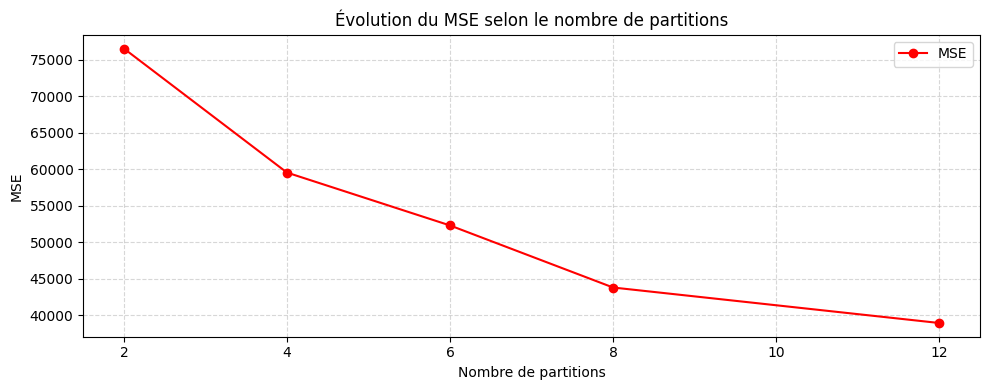

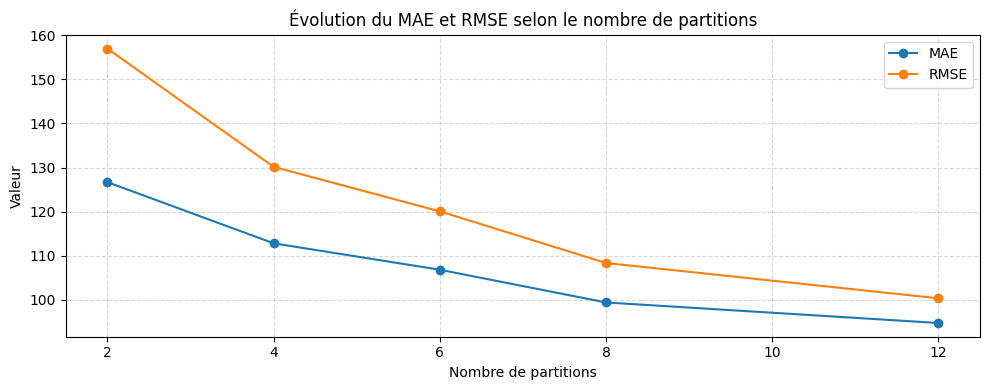

In [222]:
plt.figure(figsize=(10, 4))
plt.plot(summary_df.index, summary_df['mse_global'], marker='o', color='red', label='MSE')
plt.title("Évolution du MSE selon le nombre de partitions")
plt.xlabel("Nombre de partitions")
plt.ylabel("MSE")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(summary_df.index, summary_df['mae_global'], marker='o', label='MAE')
plt.plot(summary_df.index, summary_df['rmse_global'], marker='o', label='RMSE')
plt.title("Évolution du MAE et RMSE selon le nombre de partitions")
plt.xlabel("Nombre de partitions")
plt.ylabel("Valeur")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()